In [1]:
import pandas as pd
from plotnine import *
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes

In [2]:
_ = theme_set(dms_variants.plotnine_themes.theme_graygrid())

Follow up on whether highly abundant invalid barcodes are present in plasmid library, or are only seen in virus stocks.

Just start by pulling up a `csv` of invalid barcode counts from one virus sequencing sample, and merge it with the barcode counts from sequencing of the plasmid library, to see which barcodes match

In [3]:
virus_barcodes_invalid = (
    pd.read_csv("../results/barcode_runs/counts_invalid_by_sample/libA_220121_1_no-antibody_control_100x_1.csv")
    .drop(['library', 'sample'], axis=1)
)

plasmid_barcodes_invalid = (
    pd.read_csv("../results/barcode_runs/counts_invalid_by_sample/libA_220224_1_no-antibody_control_plasmid.csv")
    .drop(['library','sample'], axis=1)
)

In [4]:
matched_invalid = plasmid_barcodes_invalid.merge(virus_barcodes_invalid, how='inner', on='barcode', 
                                                 suffixes=('_plasmid', '_virus'))

matched_invalid.head(20)

,barcode,count_plasmid,count_virus
0,ATTTGTGCTTACCTTT,4770,1532973
1,TGCTCTTTGAAAATGC,4732,2081446
2,ATGCGGGAACGAAACG,4675,1618441
3,AGGCACTTGAACCTAT,3303,1211934
4,CCGAACCGGCATGTAT,3279,1380771
5,CTAATTTGTAAGAGCC,2364,1101880
6,CGGTTAAAAGGTCAGC,2354,870103
7,CCCAATCTGATACGCA,2092,800889
8,CTCAATAAATAGGTTA,1852,616935
9,TAGTACCGAACCGGAG,1711,503953


In [5]:
print(f'{len(virus_barcodes_invalid)} invalid barcodes in virus sequencing\n{len(plasmid_barcodes_invalid)} invalid barcodes in plasmid sequencing\n{len(matched_invalid)} overlapping invalid barcodes')

47154 invalid barcodes in virus sequencing
78447 invalid barcodes in plasmid sequencing
10034 overlapping invalid barcodes


Check rank of top invalid barcodes in plasmid library

In [6]:
plasmid_barcodes_valid = (
    pd.read_csv("../results/barcode_runs/counts_by_sample/libA_220224_1_no-antibody_control_plasmid.csv")
)

plasmid_barcodes_valid.head()

,barcode,count,library,sample
0,TTTCCATTGATTCGTA,1076,libA,220224_1_no-antibody_control_plasmid
1,TTTCTTGATTCACTAG,1065,libA,220224_1_no-antibody_control_plasmid
2,GCAAATAGTAACATAC,1028,libA,220224_1_no-antibody_control_plasmid
3,ATCGAAATACGTACCA,1014,libA,220224_1_no-antibody_control_plasmid
4,CATAAATACAGTGCAT,1010,libA,220224_1_no-antibody_control_plasmid


So it looks like the 18 top-ranked barcodes in the plasmid library are invalid. Pull these into a list for further analysis.

In [7]:
top_invalid_plasmid = plasmid_barcodes_invalid.head(18)

# also add virus counts
top_invalid = top_invalid_plasmid.merge(virus_barcodes_invalid, how='inner', 
                                        on='barcode',
                                        suffixes=('_plasmid', '_virus'))

What fraction of overall barcode abundance do these top barcodes represent, in the plasmid library and in the virus library? 

*For now just look at abundance for a single virus sample. Can expand this analysis to aggregate across all virus samples later, if that'd be informative.*

In [8]:
# Get total count of barcodes from fates csv
plasmid_bc_fates = pd.read_csv('../results/barcode_runs/fates_by_sample/libA_220224_1_no-antibody_control_plasmid.csv')
plasmid_bc_total = plasmid_bc_fates['count'].sum()

virus_bc_fates = pd.read_csv('../results/barcode_runs/fates_by_sample/libA_220121_1_no-antibody_control_100x_1.csv')
virus_bc_total = virus_bc_fates['count'].sum()

In [9]:
invalid_fraction_plasmid = top_invalid['count_plasmid'].sum() / plasmid_bc_total
invalid_fraction_virus = top_invalid['count_virus'].sum() / virus_bc_total

print(f'18 invalid barcodes represent:\n{round(100 * invalid_fraction_plasmid, 3)}% of the plasmid library,\n{round(100 * invalid_fraction_virus, 2)}% of the virus library')

18 invalid barcodes represent:
0.25% of the plasmid library,
31.53% of the virus library


### Check for invalid barcode in negative controls

During these same experiments, I also included RNA from uninfected cells, and samples run with no RT enzyme, as negative controls. After running both rounds of PCR on the negative control samples I saw a product band at the correct size and submitted this for sequencing.

Check if these top invalid barcodes were seen in sequencing of negative controls

In [10]:
no_inf_invalid = (
    pd.read_csv("../results/barcode_runs/counts_invalid_by_sample/libA_220303_1_no-antibody_control_AL049_no-infection.csv")
    .drop(['library','sample'], axis=1)
    .rename({'count': 'no-infection-count'}, axis=1)
)

no_rt_invalid = (
    pd.read_csv("../results/barcode_runs/counts_invalid_by_sample/libA_220303_1_no-antibody_control_1_AL049_no-RT.csv")
    .drop(['library','sample'], axis=1)
    .rename({'count': 'no-rt-count'}, axis=1)
)

In [11]:
bc_of_interest = top_invalid['barcode'].to_list()

no_inf_bc_match = no_inf_invalid[no_inf_invalid.barcode.isin(bc_of_interest)]
no_inf_bc_match

,barcode,no-infection-count
0,AACCGACATGACCGCA,870198
1,TGCTCTTTGAAAATGC,703731
2,ATGCGGGAACGAAACG,643665
4,CGGTTAAAAGGTCAGC,423815
5,CTAATTTGTAAGAGCC,409988
6,AGGCACTTGAACCTAT,402650
7,CCGAACCGGCATGTAT,333631
8,ATTTGTGCTTACCTTT,299024
9,CCCAATCTGATACGCA,298664
11,CACCCATGCCCTGATC,233994


In [12]:
no_rt_bc_match = no_rt_invalid[no_rt_invalid.barcode.isin(bc_of_interest)]
no_rt_bc_match

,barcode,no-rt-count
0,AACCGACATGACCGCA,1492805
1,TGCTCTTTGAAAATGC,1140800
2,ATGCGGGAACGAAACG,784483
3,ATTTGTGCTTACCTTT,662281
4,AGGCACTTGAACCTAT,556246
5,CCGAACCGGCATGTAT,544051
6,CTAATTTGTAAGAGCC,474402
7,CACCCATGCCCTGATC,464755
8,CGGTTAAAAGGTCAGC,458770
9,CGATAAACGCTAAACT,448900


The same 18 barcodes are seen in both negative controls! Furthermore, the counts for each are very high. Compare to counts in barcode and virus libraries - 

In [13]:
invalid_all_samples = matched_invalid.merge(no_inf_invalid, how='inner', on='barcode')
invalid_all_samples = invalid_all_samples.merge(no_rt_invalid, how='inner', on='barcode')

cols_dict = {'count_plasmid': 'plasmid', 'count_virus': 'virus', 'no-infection-count': 'no-infection',
             'no-rt-count': 'no-RT'
            }

invalid_all_samples = invalid_all_samples.rename(columns=cols_dict)
invalid_all_samples

,barcode,plasmid,virus,no-infection,no-RT
0,ATTTGTGCTTACCTTT,4770,1532973,299024,662281
1,TGCTCTTTGAAAATGC,4732,2081446,703731,1140800
2,ATGCGGGAACGAAACG,4675,1618441,643665,784483
3,AGGCACTTGAACCTAT,3303,1211934,402650,556246
4,CCGAACCGGCATGTAT,3279,1380771,333631,544051
...,...,...,...,...,...
1183,TTAGTCGTGTGCAAAA,1,43,7,15
1184,TTCAATAAATAGGTTA,1,80,24,18
1185,TTCCTTCACATACTCA,1,17,7,9
1186,TTGACGTAAGGTACGA,1,2,1,2


There are 1000 barcodes that are seen in all invalid samples across plasmid, virus, and negative control sequencing. Plot the counts for top-ranked barcodes for easier analysis - 

In [14]:
top_invalid_all_samples = invalid_all_samples[invalid_all_samples.barcode.isin(bc_of_interest)]
top_invalid_all_samples = top_invalid_all_samples.melt(id_vars=['barcode'], 
                                                       value_vars = ['virus', 'plasmid', 'no-infection', 'no-RT'],
                                                       var_name='sample',
                                                       value_name='count'
                                                      )
top_invalid_all_samples

,barcode,sample,count
0,ATTTGTGCTTACCTTT,virus,1532973
1,TGCTCTTTGAAAATGC,virus,2081446
2,ATGCGGGAACGAAACG,virus,1618441
3,AGGCACTTGAACCTAT,virus,1211934
4,CCGAACCGGCATGTAT,virus,1380771
...,...,...,...
67,TCCTGACCTCACATTT,no-RT,134254
68,TTAGTCGTATGCAAAA,no-RT,239436
69,ATTACGCAATTCAATA,no-RT,179644
70,AACCGACATGACCGCA,no-RT,1492805


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 5 in image.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: scratch_figs/invalid_bc_negative_ctrls.pdf


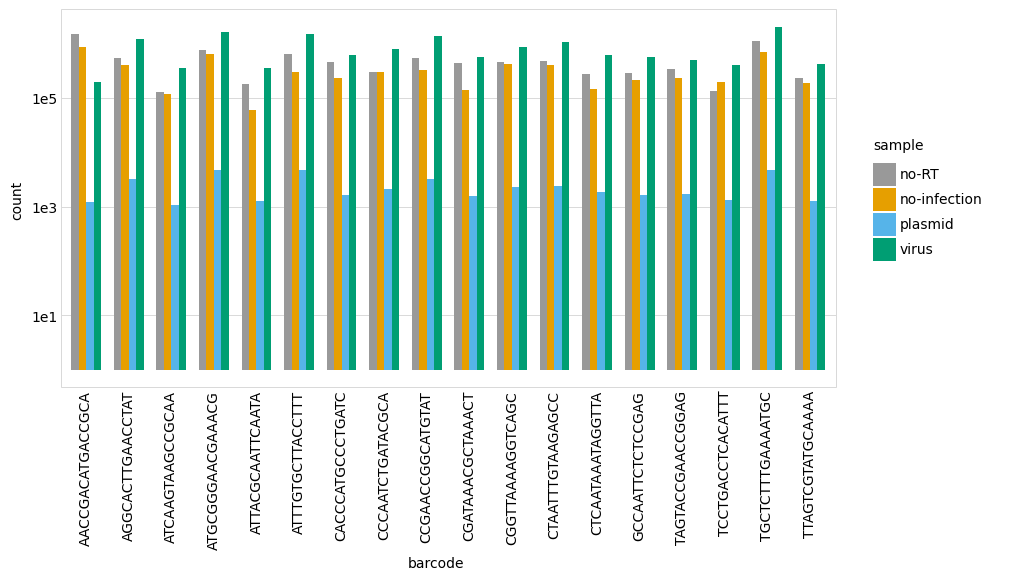

In [15]:
p = (
    ggplot(
        top_invalid_all_samples,
        aes(x='barcode', y='count', fill='sample')) +
    geom_col(position='dodge', width=0.7) + 
    theme(figure_size=(10, 5),
          panel_grid_major_x=element_blank(),
          axis_text_x=element_text(rotation=90)
         ) + 
    scale_y_log10() + 
    scale_fill_manual(values=CBPALETTE)
)

_ = p.draw()

p.save('scratch_figs/invalid_bc_negative_ctrls.pdf')

When visualized on a log scale, we can see that counts of these barcodes in the negative controls are very similar to counts in the virus library. They're also present in the plasmid library - note that overall counts are lower, but these are still the top-ranked barcodes.

To me, these results indicate that invalid barcodes are likely due to contamination in the Round1 / Round2 PCR's for Illumina sequencing prep.